,시군구,침엽수_비율,활엽수_비율,산불_피해면적합계,산불_발생횟수,대표_계절,대표_시간대,산불_평균피해면적
0,강남구,18.88,81.12,18000.0,1.0,봄,오후,18000.000000
1,강동구,15.79,84.21,NaN,NaN,기타,기타,0.000000
2,강북구,24.26,75.74,100.0,1.0,봄,오후,100.000000
3,강서구,14.36,85.64,34100.0,4.0,겨울,오후,8525.000000
4,계양구,0.00,100.00,100.0,1.0,봄,새벽,100.000000
5,고양시 덕양구,7.87,92.13,NaN,NaN,기타,기타,0.000000
6,과천시,28.75,71.25,43600.0,6.0,봄,오후,7266.666667
7,관악구,41.25,58.75,400.0,3.0,여름,오후,133.333333
8,광명시,21.65,78.35,NaN,NaN,기타,기타,0.000000
9,광진구,60.26,39.74,NaN,NaN,기타,기타,0.000000


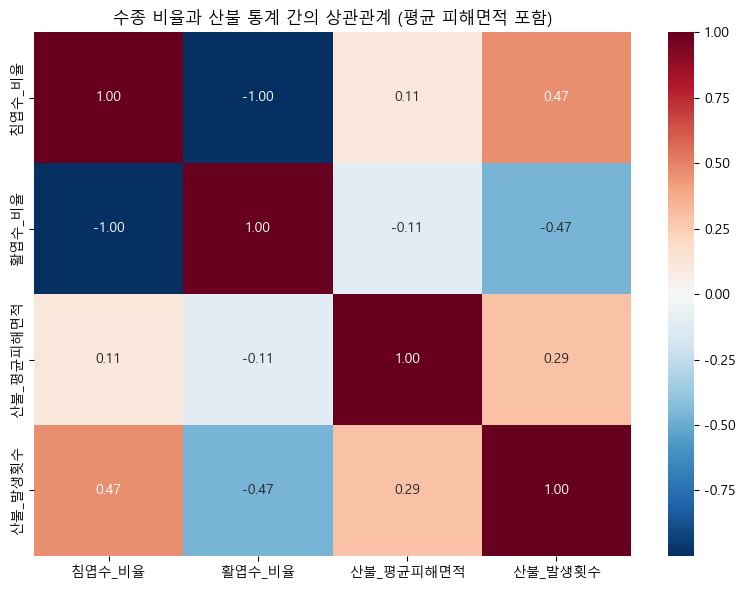

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.font_manager as fm
import seaborn as sns

# 윈도우용 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False 

# 데이터 로드
tree_ratio = pd.read_csv("C:/Users/sangj/Desktop/data/임상도_서울특별시/시군구별_수종비율.csv", encoding="utf-8-sig")
fire = pd.read_csv("C:/Users/sangj/Desktop/data/산불데이터_전처리.csv", encoding="utf-8-sig")

# 시군구 기준 집계
fire_summary = fire.groupby("시군구").agg(
    산불_피해면적합계=("피해면적_m2", "sum"),
    산불_발생횟수=("피해면적_m2", "count")
).reset_index()

# 병합
tree_ratio = tree_ratio.rename(columns={"시군구명": "시군구"})

merged["산불_평균피해면적"] = merged["산불_피해면적합계"] / merged["산불_발생횟수"]
merged["산불_평균피해면적"] = merged["산불_평균피해면적"].fillna(0)  # 0으로 채움

display(merged.head(20))
# 새로운 상관 분석
correlation = merged[["침엽수_비율", "활엽수_비율", "산불_평균피해면적", "산불_발생횟수"]].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap="RdBu_r", fmt=".2f")
plt.title("수종 비율과 산불 통계 간의 상관관계 (평균 피해면적 포함)")
plt.tight_layout()
plt.show()

기울기(계수): 0.06877614405467607
절편: 0.4647705918584646
R^2 (설명력): 0.06409030563802431


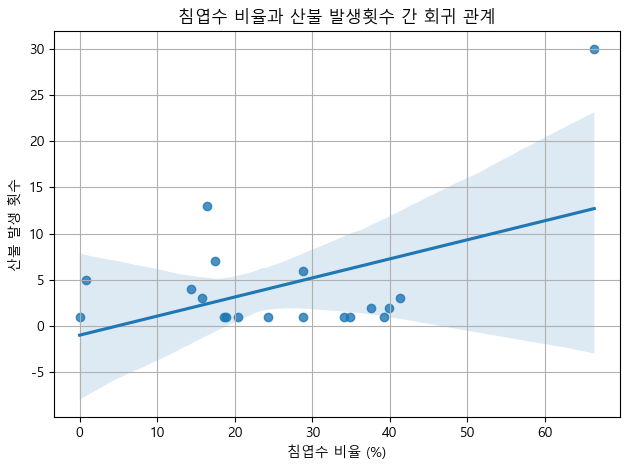

In [34]:
from sklearn.linear_model import LinearRegression
import numpy as np

X = merged[["침엽수_비율"]]
y = merged["산불_발생횟수"].fillna(0)

model = LinearRegression()
model.fit(X, y)

print("기울기(계수):", model.coef_[0])
print("절편:", model.intercept_)
print("R^2 (설명력):", model.score(X, y))

import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(data=merged, x="침엽수_비율", y="산불_발생횟수")
plt.title("침엽수 비율과 산불 발생횟수 간 회귀 관계")
plt.xlabel("침엽수 비율 (%)")
plt.ylabel("산불 발생 횟수")
plt.grid(True)
plt.tight_layout()
plt.show()

기울기(계수): 38.3627419309922
절편: 1953.2591656593895
R^2 (설명력): 0.012679218003990744


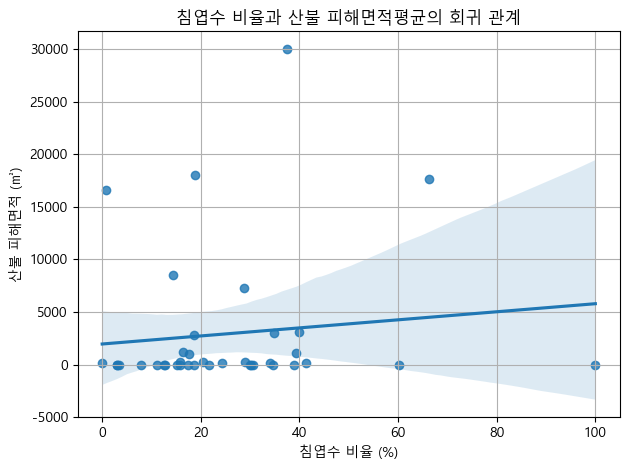

In [35]:
from sklearn.linear_model import LinearRegression
import numpy as np

X = merged[["침엽수_비율"]]
y = merged["산불_평균피해면적"]

model = LinearRegression()
model.fit(X, y)

print("기울기(계수):", model.coef_[0])
print("절편:", model.intercept_)
print("R^2 (설명력):", model.score(X, y))

import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(data=merged, x="침엽수_비율", y="산불_평균피해면적")
plt.title("침엽수 비율과 산불 피해면적평균의 회귀 관계")
plt.xlabel("침엽수 비율 (%)")
plt.ylabel("산불 피해면적 (㎡)")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ 다중 회귀 분석 완료
R² (설명력): 0.5078
RMSE (평균제곱근오차): 4612.20


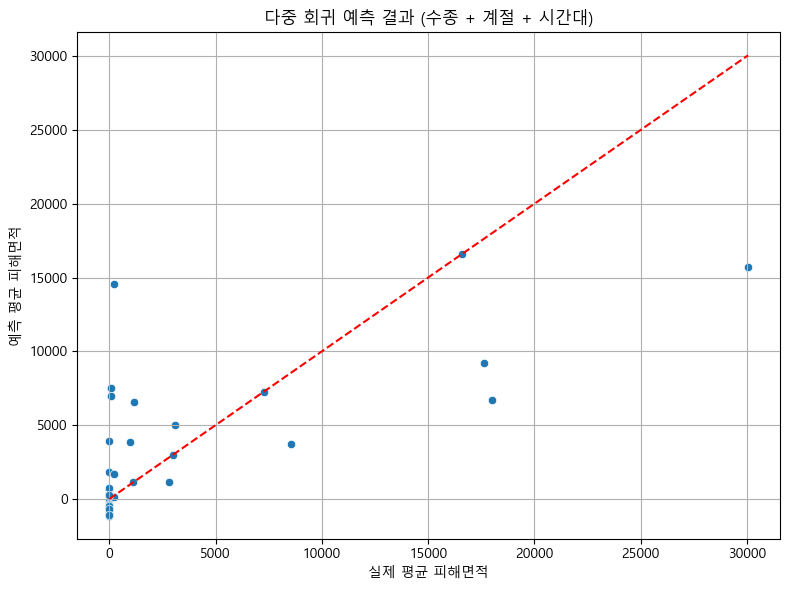

In [36]:
# 단일 회귀분석의 R^2값이 너무 낮아(유의미하지않아) 다중회귀(시간대와 계절)로 분석

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


fire_summary = fire.groupby("시군구").agg(
    산불_피해면적합계=("피해면적_m2", "sum"),
    산불_발생횟수=("피해면적_m2", "count"),
    대표_계절=("계절", lambda x: x.mode()[0] if not x.mode().empty else "기타"),
    대표_시간대=("발생시간대", lambda x: x.mode()[0] if not x.mode().empty else "기타")
).reset_index()

fire_summary["산불_평균피해면적"] = fire_summary["산불_피해면적합계"] / fire_summary["산불_발생횟수"]
fire_summary["산불_평균피해면적"] = fire_summary["산불_평균피해면적"].fillna(0)

tree_ratio = tree_ratio.rename(columns={"시군구명": "시군구"})
merged = pd.merge(tree_ratio, fire_summary, on="시군구", how="left")

# 결측값 처리
merged = merged.fillna({"산불_평균피해면적": 0, "대표_계절": "기타", "대표_시간대": "기타"})

#  특성과 타겟 정의 
X = merged[["침엽수_비율", "활엽수_비율", "대표_계절", "대표_시간대"]]
y = merged["산불_평균피해면적"]

# 범주형 인코딩 설정
categorical_features = ["대표_계절", "대표_시간대"]
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first"), categorical_features)
], remainder="passthrough")  # 수치 변수는 그대로

# 모델 파이프라인 구성 
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

# 학습
pipeline.fit(X, y)


y_pred = pipeline.predict(X)
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)

print(f" 다중 회귀 분석 완료")
print(f"R² (설명력): {r2:.4f}")
print(f"RMSE (평균제곱근오차): {rmse:.2f}")


plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred)
plt.xlabel("실제 평균 피해면적")
plt.ylabel("예측 평균 피해면적")
plt.title("다중 회귀 예측 결과 (수종 + 계절 + 시간대)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--")
plt.grid(True)
plt.tight_layout()
plt.show()
